# Introduction to Eland Webinar

- Webinar Recording on Youtube (Will update when available!)
- Webinar Slides (Will update when available!)
- [Eland Documentation](https://eland.readthedocs.io)
- [Source Code on GitHub](https://github.com/elastic/eland)
- [Elastic Cloud](https://cloud.elastic.co)
- [NYC Open Data dataset](https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/43nn-pn8j)

This Jupyter Notebook goes along with the webinar 'Introduction to Eland' which is available
on Youtube. To follow along either create an Elasticsearch deployment on Elastic Cloud (free trial available)
or start your own Elasticsearch cluster locally.

You'll need to install the following libraries:

```bash
$ python -m pip install eland numpy pandas
```

# DataFrame Demo

In [19]:
# Standard imports
import eland as ed
import pandas as pd
import numpy as np
from elasticsearch import Elasticsearch

# Function for pretty-printing JSON
def json(x):
    import json
    print(json.dumps(x, indent=2, sort_keys=True))

In [20]:
# Connect to an Elastic Cloud instance
# or another Elasticsearch index below

ELASTIC_CLOUD_ID = "<cloud-id>"
ELASTIC_CLOUD_PASSWORD = "<password>"

es = Elasticsearch(
  cloud_id=ELASTIC_CLOUD_ID,
  http_auth=("elastic", ELASTIC_CLOUD_PASSWORD)   
)
json(es.info())

{
  "cluster_name": "167e473c7bba4bae85004385d4e0ce46",
  "cluster_uuid": "4Y2FwBhRSsWq9uGedb1DmQ",
  "name": "instance-0000000000",
  "tagline": "You Know, for Search",
  "version": {
    "build_date": "2020-06-14T19:35:50.234439Z",
    "build_flavor": "default",
    "build_hash": "757314695644ea9a1dc2fecd26d1a43856725e65",
    "build_snapshot": false,
    "build_type": "docker",
    "lucene_version": "8.5.1",
    "minimum_index_compatibility_version": "6.0.0-beta1",
    "minimum_wire_compatibility_version": "6.8.0",
    "number": "7.8.0"
  }
}


In [21]:
# Load the dataset from NYC Open Data and take a look
pd_df = pd.read_csv("nyc-restaurants.csv").dropna()
pd_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 193197 entries, 0 to 400255
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   CAMIS                  193197 non-null  int64  
 1   DBA                    193197 non-null  object 
 2   BORO                   193197 non-null  object 
 3   BUILDING               193197 non-null  object 
 4   STREET                 193197 non-null  object 
 5   ZIPCODE                193197 non-null  float64
 6   PHONE                  193197 non-null  object 
 7   CUISINE DESCRIPTION    193197 non-null  object 
 8   INSPECTION DATE        193197 non-null  object 
 9   ACTION                 193197 non-null  object 
 10  VIOLATION CODE         193197 non-null  object 
 11  VIOLATION DESCRIPTION  193197 non-null  object 
 12  CRITICAL FLAG          193197 non-null  object 
 13  SCORE                  193197 non-null  float64
 14  GRADE                  193197 non-nu

In [22]:
# Rename the columns to be snake_case
pd_df.columns = [x.lower().replace(" ", "_") for x in pd_df.columns]

# Combine the 'latitude' and 'longitude' columns into one column 'location' for 'geo_point'
pd_df["location"] = pd_df[["latitude", "longitude"]].apply(lambda x: ",".join(str(item) for item in x), axis=1)

# Drop the old columns in favor of 'location'
pd_df.drop(["latitude", "longitude"], axis=1, inplace=True)

pd_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 193197 entries, 0 to 400255
Data columns (total 25 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   camis                  193197 non-null  int64  
 1   dba                    193197 non-null  object 
 2   boro                   193197 non-null  object 
 3   building               193197 non-null  object 
 4   street                 193197 non-null  object 
 5   zipcode                193197 non-null  float64
 6   phone                  193197 non-null  object 
 7   cuisine_description    193197 non-null  object 
 8   inspection_date        193197 non-null  object 
 9   action                 193197 non-null  object 
 10  violation_code         193197 non-null  object 
 11  violation_description  193197 non-null  object 
 12  critical_flag          193197 non-null  object 
 13  score                  193197 non-null  float64
 14  grade                  193197 non-nu

In [23]:
df = ed.pandas_to_eland(
    pd_df=pd_df,
    es_client=es,

    # Where the data will live in Elasticsearch
    es_dest_index="nyc-restaurants",
    
    # Type overrides for certain columns, 'location' detected
    # automatically as 'keyword' but we want these interpreted as 'geo_point'.
    es_type_overrides={
        "location": "geo_point",
        "dba": "text",
        "zipcode": "short"
    },

    # If the index already exists what should we do?
    es_if_exists="replace",
    
    # Wait for data to be indexed before returning
    es_refresh=True,
)
df.info()

<class 'eland.dataframe.DataFrame'>
Index: 193197 entries, 10388 to 398749
Data columns (total 25 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   camis                  193197 non-null  int64  
 1   dba                    193197 non-null  object 
 2   boro                   193197 non-null  object 
 3   building               193197 non-null  object 
 4   street                 193197 non-null  object 
 5   zipcode                193197 non-null  int64  
 6   phone                  193197 non-null  object 
 7   cuisine_description    193197 non-null  object 
 8   inspection_date        193197 non-null  object 
 9   action                 193197 non-null  object 
 10  violation_code         193197 non-null  object 
 11  violation_description  193197 non-null  object 
 12  critical_flag          193197 non-null  object 
 13  score                  193197 non-null  float64
 14  grade                  193197 non-null 

In [24]:
json(es.indices.get_mapping(index="nyc-restaurants"))

{
  "nyc-restaurants": {
    "mappings": {
      "properties": {
        "action": {
          "type": "keyword"
        },
        "bbl": {
          "type": "double"
        },
        "bin": {
          "type": "double"
        },
        "boro": {
          "type": "keyword"
        },
        "building": {
          "type": "keyword"
        },
        "camis": {
          "type": "long"
        },
        "census_tract": {
          "type": "double"
        },
        "community_board": {
          "type": "double"
        },
        "council_district": {
          "type": "double"
        },
        "critical_flag": {
          "type": "keyword"
        },
        "cuisine_description": {
          "type": "keyword"
        },
        "dba": {
          "type": "text"
        },
        "grade": {
          "type": "keyword"
        },
        "grade_date": {
          "type": "keyword"
        },
        "inspection_date": {
          "type": "keyword"
        },
        "inspe

In [25]:
# Shape is determined by using count API
df.shape

(193197, 25)

In [34]:
# DataFrame has many APIs compatible with Pandas

#df.head(10)
#df.columns
#df.dba
#df["grade"]
#df[df.grade.isin(["A", "B"])]
#print(df[df.grade.isin(["A", "B"])].es_info())
#print(df.tail(10).es_info())

es_index_pattern: nyc-restaurants
Index:
 es_index_field: _id
 is_source_field: False
Mappings:
 capabilities:
                               es_field_name  is_source   es_dtype es_date_format pd_dtype  is_searchable  is_aggregatable  is_scripted aggregatable_es_field_name
camis                                  camis       True       long           None    int64           True             True        False                      camis
dba                                      dba       True       text           None   object           True            False        False                       None
boro                                    boro       True    keyword           None   object           True             True        False                       boro
building                            building       True    keyword           None   object           True             True        False                   building
street                                street       True    keyword        

In [39]:
# Aggregating values
df.describe()

,camis,zipcode,score,community_board,council_district,census_tract,bin,bbl
count,1.931970e+05,193197.000000,193197.000000,193197.000000,193197.000000,193197.000000,1.931970e+05,1.931970e+05
mean,4.605010e+07,10677.212540,12.947680,248.602603,20.020715,28796.048298,2.513373e+06,2.450622e+09
std,4.415232e+06,595.142246,8.180244,130.697014,15.809664,30672.683469,1.351134e+06,1.313578e+09
min,3.011234e+07,10000.000000,-1.000000,101.000000,1.000000,100.000000,1.000000e+06,1.000000e+09
25%,4.138051e+07,10022.000000,9.000000,105.000000,4.000000,7895.605691,1.042708e+06,1.011024e+09
50%,5.000527e+07,10468.006114,12.000000,301.000000,19.747529,16022.917106,3.007191e+06,3.002924e+09
75%,5.005661e+07,11228.624535,13.000000,401.000000,34.000000,40246.000337,4.002294e+06,4.003343e+09
max,5.010416e+07,12345.000000,99.000000,503.000000,51.000000,162100.000000,5.799501e+06,5.270001e+09


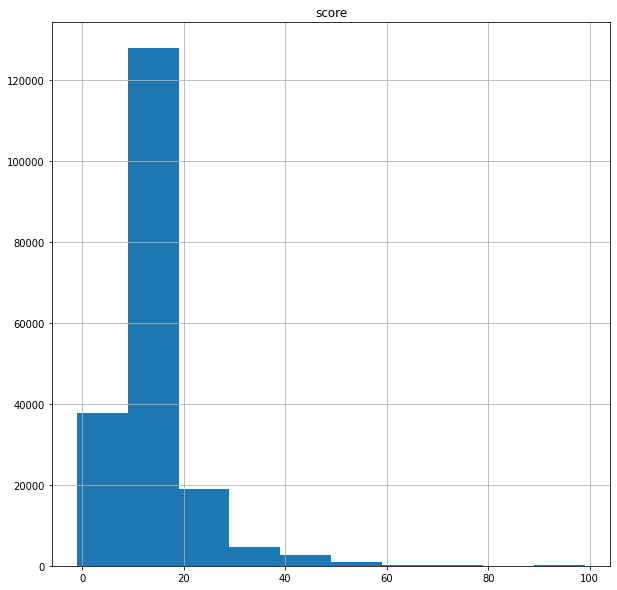

In [40]:
# Plotting with matplotlib
from matplotlib import pyplot as plt

df[["score"]].hist(figsize=[10,10])
plt.show()

In [42]:
# es_query() allows for the full Elasticsearch querying capabilities
df.es_query({
  "geo_distance": {
    "distance": "50m",
    "location": {
      "lat": 40.643852716573,
      "lon": -74.011628212186
    }
  }
})

,camis,dba,boro,building,street,zipcode,phone,cuisine_description,inspection_date,action,...,grade_date,record_date,inspection_type,community_board,council_district,census_tract,bin,bbl,nta,location
53127,41144258,BURGER KING,Brooklyn,5212,5 AVENUE,11220.0,7187650844,Hamburgers,12/26/2018,Violations were cited in the following area(s).,...,12/26/2018,07/07/2020,Cycle Inspection / Initial Inspection,307.0,38.0,7600.0,3329902.0,3.008070e+09,BK32,"40.643852716573,-74.011628212186"
61268,41144258,BURGER KING,Brooklyn,5212,5 AVENUE,11220.0,7187650844,Hamburgers,07/20/2017,Violations were cited in the following area(s).,...,07/20/2017,07/07/2020,Cycle Inspection / Initial Inspection,307.0,38.0,7600.0,3329902.0,3.008070e+09,BK32,"40.643852716573,-74.011628212186"
20717,41144258,BURGER KING,Brooklyn,5212,5 AVENUE,11220.0,7187650844,Hamburgers,03/04/2020,Violations were cited in the following area(s).,...,03/04/2020,07/07/2020,Cycle Inspection / Initial Inspection,307.0,38.0,7600.0,3329902.0,3.008070e+09,BK32,"40.643852716573,-74.011628212186"
4648,41271801,PINO'S,Brooklyn,5201,5 AVENUE,11220.0,7184396012,Pizza,05/25/2019,Violations were cited in the following area(s).,...,05/25/2019,07/07/2020,Cycle Inspection / Initial Inspection,307.0,38.0,10000.0,3013942.0,3.008080e+09,BK34,"40.643888405293005,-74.011563356969"
224,41271801,PINO'S,Brooklyn,5201,5 AVENUE,11220.0,7184396012,Pizza,05/25/2019,Violations were cited in the following area(s).,...,05/25/2019,07/07/2020,Cycle Inspection / Initial Inspection,307.0,38.0,10000.0,3013942.0,3.008080e+09,BK34,"40.643888405293005,-74.011563356969"
9465,41144258,BURGER KING,Brooklyn,5212,5 AVENUE,11220.0,7187650844,Hamburgers,03/04/2020,Violations were cited in the following area(s).,...,03/04/2020,07/07/2020,Cycle Inspection / Initial Inspection,307.0,38.0,7600.0,3329902.0,3.008070e+09,BK32,"40.643852716573,-74.011628212186"
104512,40396492,ROYAL KING'S PIZZA,Brooklyn,5211,5 AVENUE,11220.0,7184923846,Pizza,12/19/2018,Violations were cited in the following area(s).,...,12/19/2018,07/07/2020,Cycle Inspection / Initial Inspection,307.0,38.0,10000.0,3013939.0,3.008080e+09,BK34,"40.643849974348996,-74.01160298782"
106728,41271801,PINO'S,Brooklyn,5201,5 AVENUE,11220.0,7184396012,Pizza,01/25/2018,Violations were cited in the following area(s).,...,01/25/2018,07/07/2020,Cycle Inspection / Re-inspection,307.0,38.0,10000.0,3013942.0,3.008080e+09,BK34,"40.643888405293005,-74.011563356969"
62748,50004330,KFC,Brooklyn,5223,5 AVENUE,11220.0,7184922813,Chicken,05/28/2019,Violations were cited in the following area(s).,...,05/28/2019,07/07/2020,Cycle Inspection / Initial Inspection,307.0,38.0,10000.0,3013937.0,3.008080e+09,BK34,"40.643800563168,-74.01165342693001"
79211,41271801,PINO'S,Brooklyn,5201,5 AVENUE,11220.0,7184396012,Pizza,11/05/2016,Violations were cited in the following area(s).,...,11/05/2016,07/07/2020,Cycle Inspection / Initial Inspection,307.0,38.0,10000.0,3013942.0,3.008080e+09,BK34,"40.643888405293005,-74.011563356969"


In [43]:
# Full-text search example
df.es_query({"match": {"dba": "red"}})

,camis,dba,boro,building,street,zipcode,phone,cuisine_description,inspection_date,action,...,grade_date,record_date,inspection_type,community_board,council_district,census_tract,bin,bbl,nta,location
5765,50033781,RED HOOK LOBSTER POUND,Brooklyn,284,VAN BRUNT STREET,11231.0,7188587650,Seafood,04/19/2018,Violations were cited in the following area(s).,...,04/19/2018,07/07/2020,Cycle Inspection / Initial Inspection,306.0,38.0,5900.0,3008365.0,3.005290e+09,BK33,"40.67974632809,-74.010098611838"
12379,50058053,RED HOT II,Brooklyn,349,7 AVENUE,11215.0,7183692577,Chinese,05/17/2018,Violations were cited in the following area(s).,...,05/17/2018,07/07/2020,Cycle Inspection / Re-inspection,306.0,39.0,15100.0,3026127.0,3.010940e+09,BK37,"40.666194419994,-73.98214269199799"
12978,50059700,RED POKE,Manhattan,600,9 AVENUE,10036.0,2129748100,Hawaiian,03/21/2017,Violations were cited in the following area(s).,...,03/21/2017,07/07/2020,Pre-permit (Operational) / Re-inspection,104.0,3.0,12100.0,1088997.0,1.010330e+09,MN15,"40.758993434643,-73.992203122611"
16759,40365239,DORRIAN'S RED HAND RESTAURANT,Manhattan,1616,2 AVENUE,10028.0,2127726660,Irish,11/08/2018,Violations were cited in the following area(s).,...,11/08/2018,07/07/2020,Cycle Inspection / Initial Inspection,108.0,5.0,13800.0,1049947.0,1.015460e+09,MN32,"40.776404966262,-73.952802065662"
18624,50095340,RED PEONY CHINESE CUISINE,Manhattan,24,WEST 56 STREET,10019.0,2123808883,Chinese,11/21/2019,Violations were cited in the following area(s).,...,11/21/2019,07/07/2020,Pre-permit (Operational) / Re-inspection,105.0,4.0,10400.0,1034840.0,1.012710e+09,MN17,"40.762699245064,-73.975463733228"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391229,50061162,CODE RED,Bronx,1320,EAST GUN HILL ROAD,10469.0,7188811808,Caribbean,05/14/2018,Violations were cited in the following area(s).,...,05/14/2018,07/07/2020,Cycle Inspection / Initial Inspection,211.0,12.0,35000.0,2056100.0,2.045890e+09,BX31,"40.871378316318996,-73.848028279305"
393531,50014078,RED LOBSTER,Manhattan,5,TIMES SQ,10036.0,2127306706,Seafood,11/08/2017,Violations were cited in the following area(s).,...,11/08/2017,07/07/2020,Cycle Inspection / Re-inspection,105.0,3.0,11300.0,1024656.0,1.010130e+09,MN17,"40.755702020307005,-73.987207980138"
396171,40368313,RED FLAME DINER,Manhattan,67,WEST 44 STREET,10036.0,2128693965,American,02/16/2018,Violations were cited in the following area(s).,...,02/16/2018,07/07/2020,Cycle Inspection / Initial Inspection,105.0,4.0,9600.0,1034217.0,1.012600e+09,MN17,"40.755627203336,-73.981938150269"
396501,50068499,RED GINGER,Staten Island,1650,RICHMOND AVENUE,10314.0,7189828808,Other,09/19/2017,Violations were cited in the following area(s).,...,09/19/2017,07/07/2020,Pre-permit (Operational) / Initial Inspection,502.0,50.0,29103.0,5037014.0,5.022360e+09,SI05,"40.608078102502,-74.162260908042"


In [44]:
# Pull a subset of your data for building graphs / operations locally.
sample_df = df[df.grade == "B"].sample(100).to_pandas()
sample_df.info()
print(type(sample_df))

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 107677 to 96813
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   camis                  100 non-null    int64  
 1   dba                    100 non-null    object 
 2   boro                   100 non-null    object 
 3   building               100 non-null    object 
 4   street                 100 non-null    object 
 5   zipcode                100 non-null    float64
 6   phone                  100 non-null    object 
 7   cuisine_description    100 non-null    object 
 8   inspection_date        100 non-null    object 
 9   action                 100 non-null    object 
 10  violation_code         100 non-null    object 
 11  violation_description  100 non-null    object 
 12  critical_flag          100 non-null    object 
 13  score                  100 non-null    float64
 14  grade                  100 non-null    object 
 15  grad

# Machine Learning Demo

In [45]:
# Import scikit-learn and train a dataset locally
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier

# Train the data locally
digits = datasets.load_wine()
print("Feature Names:", digits.feature_names)
print("Data example:", digits.data[0])

# Save 10, 80, and 140 for testing our model
data = [x for i, x in enumerate(digits.data) if i not in (10, 80, 140)]
target = [x for i, x in enumerate(digits.target) if i not in (10, 80, 140)]

sk_classifier = DecisionTreeClassifier()
sk_classifier.fit(data, target)

# Test out our model against the three targets
print(sk_classifier.predict(digits.data[[10, 80, 140]]))
print(digits.target[[10, 80, 140]])

Feature Names: ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
Data example: [1.423e+01 1.710e+00 2.430e+00 1.560e+01 1.270e+02 2.800e+00 3.060e+00
 2.800e-01 2.290e+00 5.640e+00 1.040e+00 3.920e+00 1.065e+03]
[0 1 2]
[0 1 2]


In [46]:
from eland.ml import ImportedMLModel

# Serialize the scikit-learn model into Elasticsearch
ed_classifier = ImportedMLModel(
  es_client=es,
  model_id="wine-classifier",
  model=sk_classifier,
  feature_names=digits.feature_names,
  overwrite=True
)

# Capture the Elasticsearch API call w/ logging
import logging
logger = logging.getLogger("elasticsearch")
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler())

# Use the same data as before, but now with the model in Elasticsearch
print(ed_classifier.predict(digits.data[[10, 80, 140]].tolist()))
print(digits.target[[10, 80, 140]])

logger.handlers = []

POST https://167e473c7bba4bae85004385d4e0ce46.us-central1.gcp.cloud.es.io/_ingest/pipeline/_simulate [status:200 request:0.053s]
> {"pipeline":{"processors":[{"inference":{"model_id":"wine-classifier","inference_config":{"classification":{}},"field_map":{}}}]},"docs":[{"_source":{"alcohol":14.1,"malic_acid":2.16,"ash":2.3,"alcalinity_of_ash":18.0,"magnesium":105.0,"total_phenols":2.95,"flavanoids":3.32,"nonflavanoid_phenols":0.22,"proanthocyanins":2.38,"color_intensity":5.75,"hue":1.25,"od280/od315_of_diluted_wines":3.17,"proline":1510.0}},{"_source":{"alcohol":12.0,"malic_acid":0.92,"ash":2.0,"alcalinity_of_ash":19.0,"magnesium":86.0,"total_phenols":2.42,"flavanoids":2.26,"nonflavanoid_phenols":0.3,"proanthocyanins":1.43,"color_intensity":2.5,"hue":1.38,"od280/od315_of_diluted_wines":3.12,"proline":278.0}},{"_source":{"alcohol":12.93,"malic_acid":2.81,"ash":2.7,"alcalinity_of_ash":21.0,"magnesium":96.0,"total_phenols":1.54,"flavanoids":0.5,"nonflavanoid_phenols":0.53,"proanthocyanins"

[0 1 2]
[0 1 2]


In [47]:
json({"pipeline":{"processors":[{"inference":{"model_id":"wine-classifier","inference_config":{"classification":{}},"field_map":{}}}]},"docs":[{"_source":{"alcohol":14.1,"malic_acid":2.16,"ash":2.3,"alcalinity_of_ash":18.0,"magnesium":105.0,"total_phenols":2.95,"flavanoids":3.32,"nonflavanoid_phenols":0.22,"proanthocyanins":2.38,"color_intensity":5.75,"hue":1.25,"od280/od315_of_diluted_wines":3.17,"proline":1510.0}},{"_source":{"alcohol":12.0,"malic_acid":0.92,"ash":2.0,"alcalinity_of_ash":19.0,"magnesium":86.0,"total_phenols":2.42,"flavanoids":2.26,"nonflavanoid_phenols":0.3,"proanthocyanins":1.43,"color_intensity":2.5,"hue":1.38,"od280/od315_of_diluted_wines":3.12,"proline":278.0}},{"_source":{"alcohol":12.93,"malic_acid":2.81,"ash":2.7,"alcalinity_of_ash":21.0,"magnesium":96.0,"total_phenols":1.54,"flavanoids":0.5,"nonflavanoid_phenols":0.53,"proanthocyanins":0.75,"color_intensity":4.6,"hue":0.77,"od280/od315_of_diluted_wines":2.31,"proline":600.0}}]})

{
  "docs": [
    {
      "_source": {
        "alcalinity_of_ash": 18.0,
        "alcohol": 14.1,
        "ash": 2.3,
        "color_intensity": 5.75,
        "flavanoids": 3.32,
        "hue": 1.25,
        "magnesium": 105.0,
        "malic_acid": 2.16,
        "nonflavanoid_phenols": 0.22,
        "od280/od315_of_diluted_wines": 3.17,
        "proanthocyanins": 2.38,
        "proline": 1510.0,
        "total_phenols": 2.95
      }
    },
    {
      "_source": {
        "alcalinity_of_ash": 19.0,
        "alcohol": 12.0,
        "ash": 2.0,
        "color_intensity": 2.5,
        "flavanoids": 2.26,
        "hue": 1.38,
        "magnesium": 86.0,
        "malic_acid": 0.92,
        "nonflavanoid_phenols": 0.3,
        "od280/od315_of_diluted_wines": 3.12,
        "proanthocyanins": 1.43,
        "proline": 278.0,
        "total_phenols": 2.42
      }
    },
    {
      "_source": {
        "alcalinity_of_ash": 21.0,
        "alcohol": 12.93,
        "ash": 2.7,
        "color_inten

In [48]:
json({"docs":[{"doc":{"_index":"_index","_type":"_doc","_id":"_id","_source":{"alcohol":14.1,"alcalinity_of_ash":18.0,"proanthocyanins":2.38,"od280/od315_of_diluted_wines":3.17,"total_phenols":2.95,"magnesium":105.0,"flavanoids":3.32,"proline":1510.0,"malic_acid":2.16,"ash":2.3,"nonflavanoid_phenols":0.22,"hue":1.25,"color_intensity":5.75,"ml":{"inference":{"predicted_value":"0","model_id":"wine-classifier"}}},"_ingest":{"timestamp":"2020-07-08T15:35:49.98965Z"}}},{"doc":{"_index":"_index","_type":"_doc","_id":"_id","_source":{"alcohol":12.0,"alcalinity_of_ash":19.0,"proanthocyanins":1.43,"od280/od315_of_diluted_wines":3.12,"total_phenols":2.42,"magnesium":86.0,"flavanoids":2.26,"proline":278.0,"malic_acid":0.92,"ash":2.0,"nonflavanoid_phenols":0.3,"hue":1.38,"color_intensity":2.5,"ml":{"inference":{"predicted_value":"1","model_id":"wine-classifier"}}},"_ingest":{"timestamp":"2020-07-08T15:35:49.98966Z"}}},{"doc":{"_index":"_index","_type":"_doc","_id":"_id","_source":{"alcohol":12.93,"alcalinity_of_ash":21.0,"proanthocyanins":0.75,"od280/od315_of_diluted_wines":2.31,"total_phenols":1.54,"magnesium":96.0,"flavanoids":0.5,"proline":600.0,"malic_acid":2.81,"ash":2.7,"nonflavanoid_phenols":0.53,"hue":0.77,"color_intensity":4.6,"ml":{"inference":{"predicted_value":"2","model_id":"wine-classifier"}}},"_ingest":{"timestamp":"2020-07-08T15:35:49.989672Z"}}}]})

{
  "docs": [
    {
      "doc": {
        "_id": "_id",
        "_index": "_index",
        "_ingest": {
          "timestamp": "2020-07-08T15:35:49.98965Z"
        },
        "_source": {
          "alcalinity_of_ash": 18.0,
          "alcohol": 14.1,
          "ash": 2.3,
          "color_intensity": 5.75,
          "flavanoids": 3.32,
          "hue": 1.25,
          "magnesium": 105.0,
          "malic_acid": 2.16,
          "ml": {
            "inference": {
              "model_id": "wine-classifier",
              "predicted_value": "0"
            }
          },
          "nonflavanoid_phenols": 0.22,
          "od280/od315_of_diluted_wines": 3.17,
          "proanthocyanins": 2.38,
          "proline": 1510.0,
          "total_phenols": 2.95
        },
        "_type": "_doc"
      }
    },
    {
      "doc": {
        "_id": "_id",
        "_index": "_index",
        "_ingest": {
          "timestamp": "2020-07-08T15:35:49.98966Z"
        },
        "_source": {
          "a

In [50]:
print(df[df["zipcode"] > df["score"]].es_info())

es_index_pattern: nyc-restaurants
Index:
 es_index_field: _id
 is_source_field: False
Mappings:
 capabilities:
                               es_field_name  is_source   es_dtype es_date_format pd_dtype  is_searchable  is_aggregatable  is_scripted aggregatable_es_field_name
camis                                  camis       True       long           None    int64           True             True        False                      camis
dba                                      dba       True       text           None   object           True            False        False                       None
boro                                    boro       True    keyword           None   object           True             True        False                       boro
building                            building       True    keyword           None   object           True             True        False                   building
street                                street       True    keyword        